## House Analysis

In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd() + "/../..")
from utils import unpack_hierarchical_data_frame
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [2]:
meta, data =pd.read_pickle("../../data/forecast_data_2020.p")

In [3]:
homes_indexes = data.columns.get_level_values(0).unique()

In [4]:
data["123"]

,temperature,humidity,cloudiness,consumption
time,,,,
2020-01-01 00:00:00,4.310000000000,72.0,99.0,4.127000000000
2020-01-01 01:00:00,4.600000000000,73.0,99.0,4.148000000000
2020-01-01 02:00:00,4.500000000000,75.0,100.0,3.828000000000
2020-01-01 03:00:00,4.640000000000,75.0,96.0,4.375000000000
2020-01-01 04:00:00,4.480000000000,75.0,100.0,4.622000000000
...,...,...,...,...
2020-12-31 20:00:00,0.220000000000,99.0,97.0,3.915000000000
2020-12-31 21:00:00,0.420000000000,100.0,99.0,1.835000000000
2020-12-31 22:00:00,0.420000000000,100.0,99.0,3.854000000000


## Basic Features

In [25]:
data_feat_descr ={"home_num": []}
for feat in data["123"].columns:
    data_feat_descr[f"{feat}_avg"]=[]
    data_feat_descr[f"{feat}_std"]=[]
    data_feat_descr[f"{feat}_max"]=[]
    data_feat_descr[f"{feat}_min"]=[]

for home_num in homes_indexes:
    data_feat_descr["home_num"].append(home_num)
    for feat in data[home_num].columns:
        data_feat_descr[f"{feat}_avg"].append(np.mean(data[home_num][feat].astype(float)))
        data_feat_descr[f"{feat}_std"].append(np.std(data[home_num][feat].astype(float)))
        data_feat_descr[f"{feat}_max"].append(np.max(data[home_num][feat].astype(float)))
        data_feat_descr[f"{feat}_min"].append(np.min(data[home_num][feat].astype(float)))

In [26]:
data_feat_descr_df = pd.DataFrame(data_feat_descr).set_index("home_num")

In [27]:
data_feat_descr_df

,temperature_avg,temperature_std,temperature_max,temperature_min,humidity_avg,humidity_std,humidity_max,humidity_min,cloudiness_avg,cloudiness_std,cloudiness_max,cloudiness_min,consumption_avg,consumption_std,consumption_max,consumption_min
home_num,,,,,,,,,,,,,,,,
854,7.868519,7.071587,29.20,-7.61,74.743024,20.013276,100.0,12.0,64.280554,37.532766,100.0,0.0,2.893879,1.646618,9.882,0.259
123,9.479780,6.259427,28.53,-4.70,74.841480,17.253693,100.0,25.0,60.414406,38.517227,100.0,0.0,2.173687,1.698909,9.571,0.093
852,8.811039,6.848238,30.43,-5.87,74.320854,19.732563,100.0,17.0,62.404881,38.264498,100.0,0.0,3.059134,1.631799,9.103,0.421
222,9.406821,6.241654,28.94,-5.26,76.136031,17.791198,100.0,22.0,60.840969,39.120266,100.0,0.0,2.245492,1.351246,7.860,0.320
484,8.313985,7.015250,30.14,-6.99,73.703916,19.445464,100.0,15.0,62.653162,38.336388,100.0,0.0,2.617564,1.778882,12.426,0.287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,8.469748,7.188199,30.53,-7.87,74.883914,20.023776,100.0,15.0,63.645476,37.856753,100.0,0.0,3.905317,1.761891,11.888,0.657
412,8.363114,7.140865,30.45,-7.44,75.179669,20.149674,100.0,13.0,63.715098,38.031963,100.0,0.0,2.678681,1.707821,11.593,0.162
261,8.227843,7.017293,29.40,-7.70,74.469656,20.175544,100.0,12.0,63.605449,37.713242,100.0,0.0,3.801180,2.554159,14.508,0.424


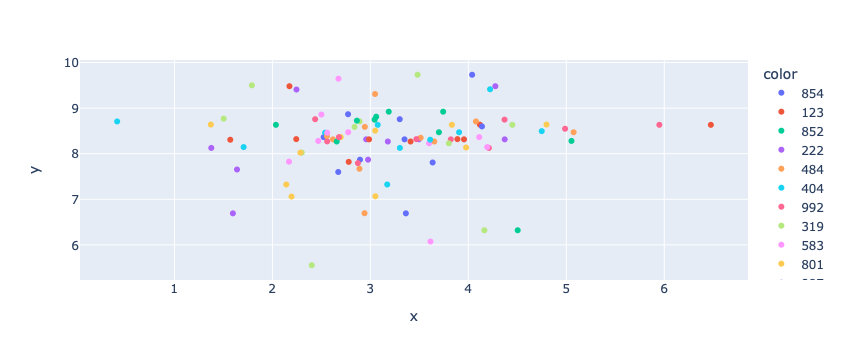

In [33]:
fig = px.scatter(x=data_feat_descr_df["consumption_avg"], y=data_feat_descr_df["temperature_avg"],
                color = data_feat_descr_df.reset_index()["home_num"])
fig.show()

## Dimensionality Reduction

In [41]:
scaled_data = StandardScaler().fit_transform(data_feat_descr_df)
pca = PCA(n_components=10)
pca.fit(scaled_data)

PCA(n_components=10)

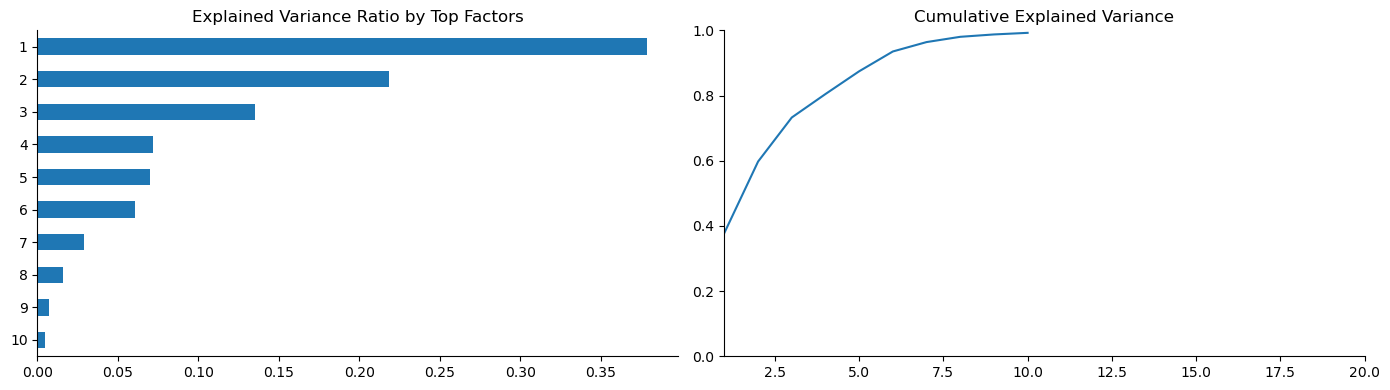

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(pca.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 20))
sns.despine()
fig.tight_layout()

In [44]:
pca_compoments = pd.DataFrame(pca.transform(scaled_data)[:, :3], 
                            columns=[f'Principal Component {i+1}' for i in range(3)], 
                            index=data_feat_descr_df.index)

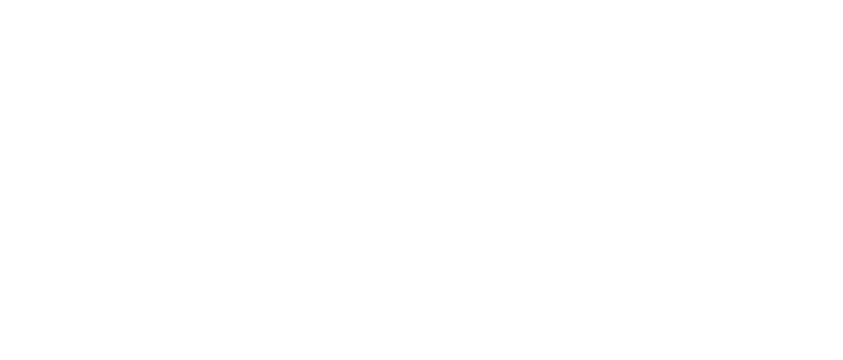

In [54]:
df = px.data.gapminder()
fig = px.scatter_3d(pca_compoments.reset_index(), x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
                    hover_data=['home_num'])
fig.update_layout(
    margin=dict(l=90, r=30, t=90, b=30),
)


## Corr Analysis

In [8]:
df_unpack = unpack_hierarchical_data_frame(data)

#### Consumption

In [17]:
cons = pd.pivot_table(df_unpack.reset_index(), values = "consumption", index = "time", columns = "home_num")

/Users/efim/opt/anaconda3/envs/EnergyForecasting/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


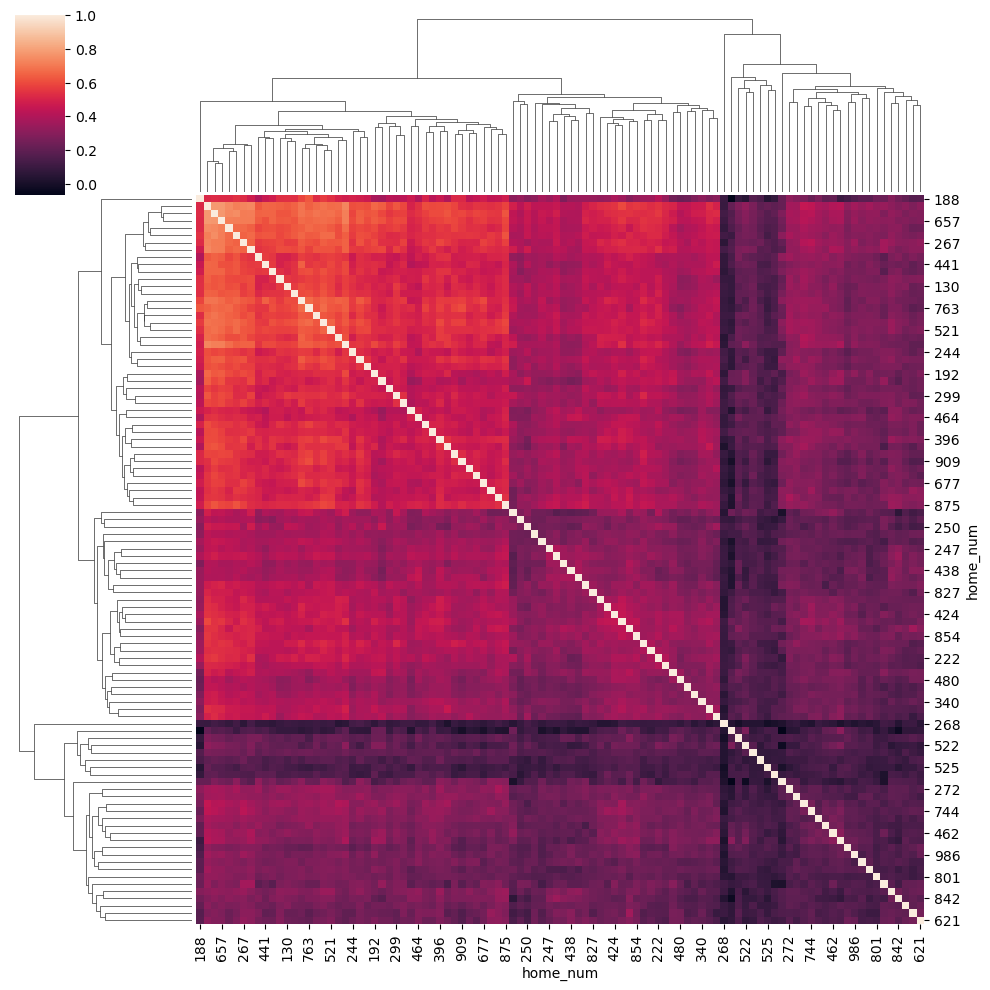

In [19]:
sns.clustermap(cons.corr())

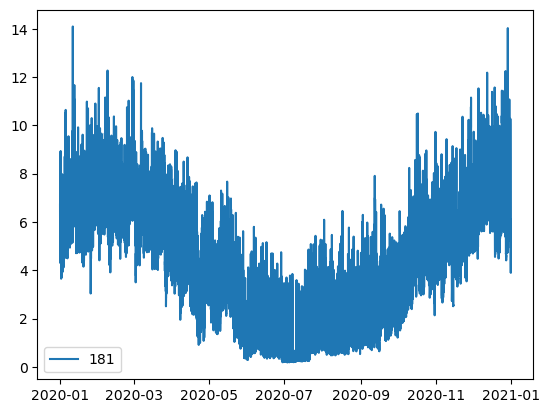

In [45]:
plt.plot(data["657"].consumption, label="181")
plt.legend()

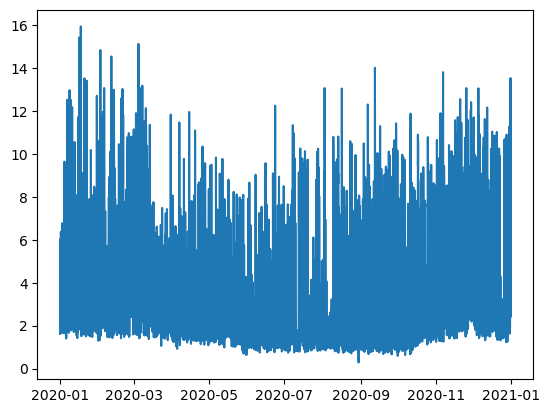

In [46]:
plt.plot(data["621"].consumption, label="621")

#### Temperature

In [21]:
temp = pd.pivot_table(df_unpack.reset_index(), values = "temperature", index = "time", columns = "home_num")

/Users/efim/opt/anaconda3/envs/EnergyForecasting/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


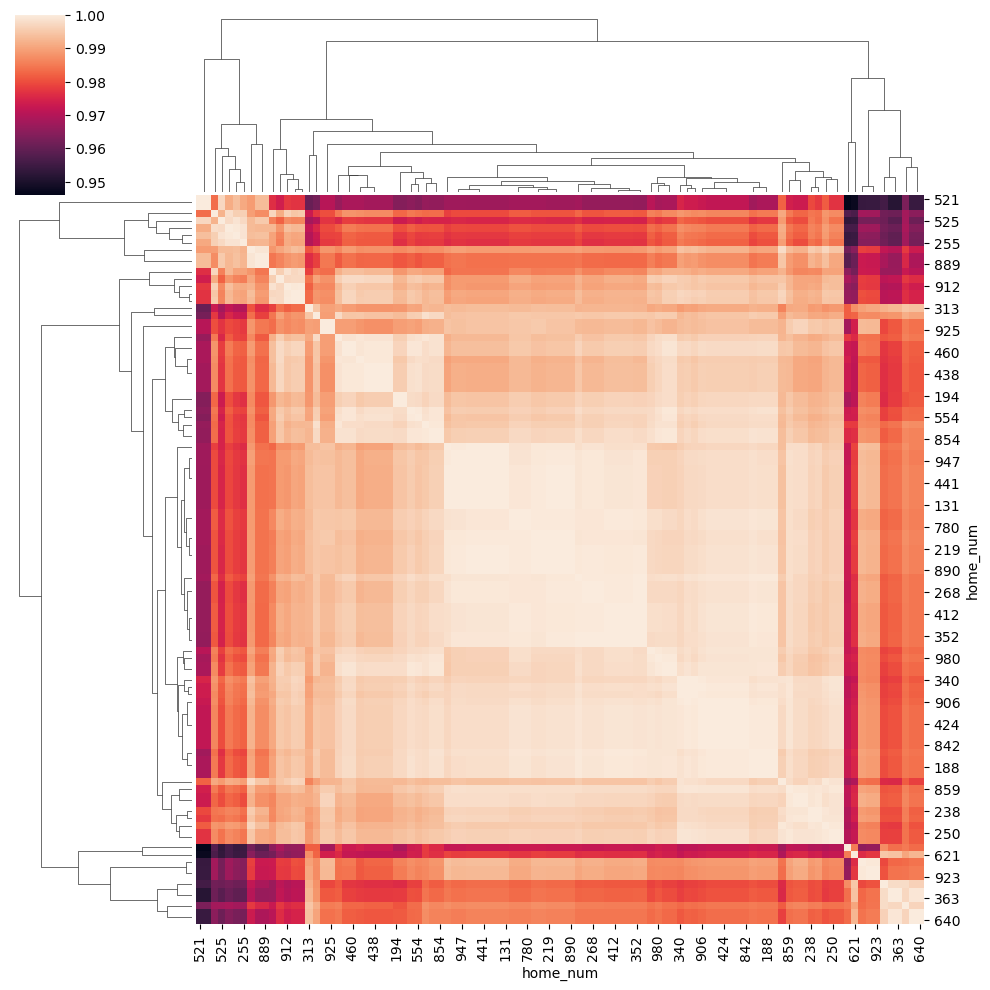

In [22]:
sns.clustermap(temp.corr())

## Clusterring

In [147]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

cons_corr=cons.corr()

kmeans = KMeans(n_clusters=2)
kmeans.fit(cons_corr)
clusters = kmeans.predict(cons_corr)

/Users/efim/opt/anaconda3/envs/EnergyForecasting/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



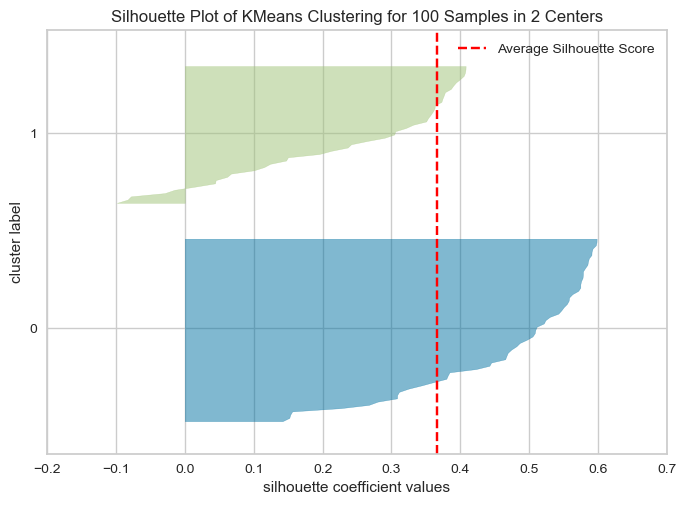

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 100 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [148]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(cons_corr)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [149]:
import scipy.cluster.hierarchy as spc



pdist = spc.distance.pdist(cons_corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.9 * pdist.max(), 'distance')

In [150]:
df_clusters = pd.DataFrame({"clusters": idx, "home_num":cons_corr.index})

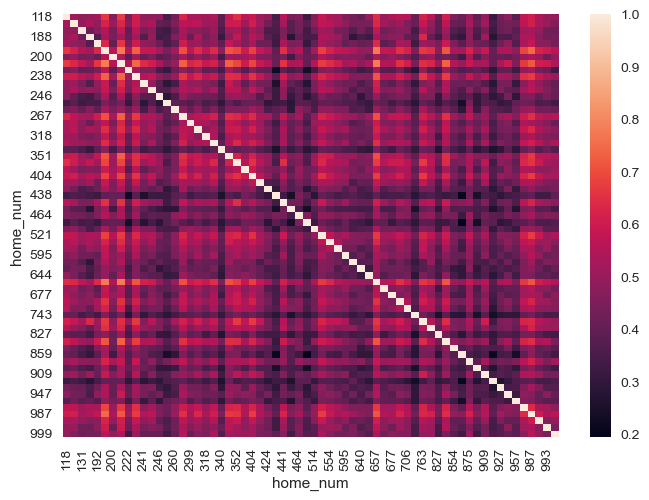

KeyboardInterrupt: 

In [142]:
for clust in [1,2]:
    home_nums = df_clusters[df_clusters.clusters ==clust].home_num
    new_data_dict = {num: data[num] for num in home_nums}
    df_unpack_ = pd.DataFrame()
    for homes in new_data_dict.keys():
        df_home = new_data_dict[homes].copy()
        df_home["home_num"] = homes
        df_unpack_ = pd.concat([df_unpack_,df_home])
    cluster_cons = pd.pivot_table(df_unpack_.reset_index(), values = "consumption", index = "time", columns = "home_num")
    sns.heatmap(cluster_cons.corr())
    plt.show()

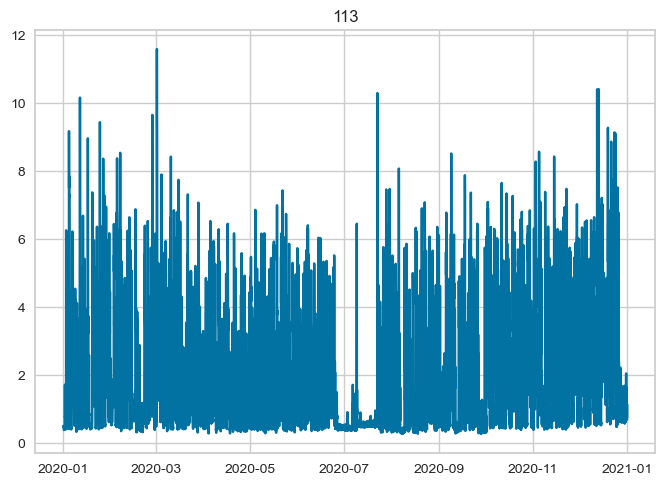

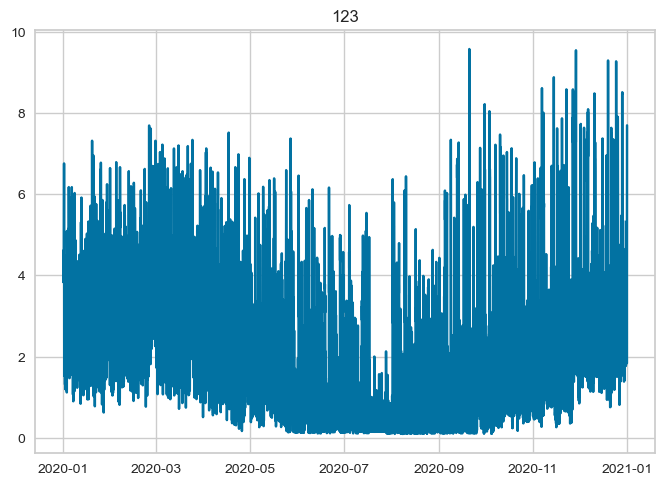

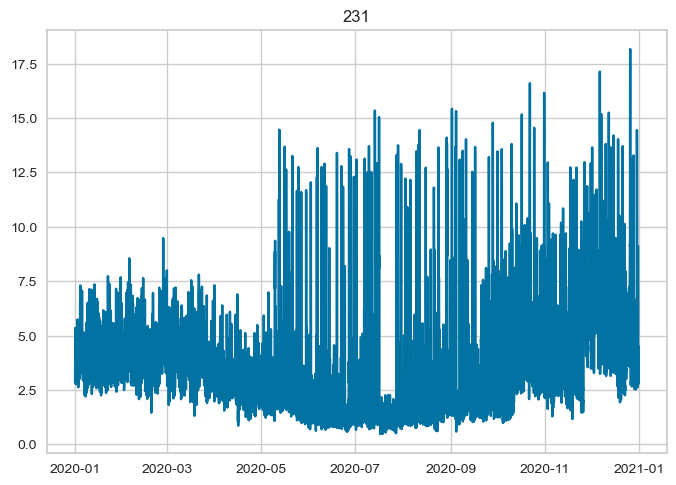

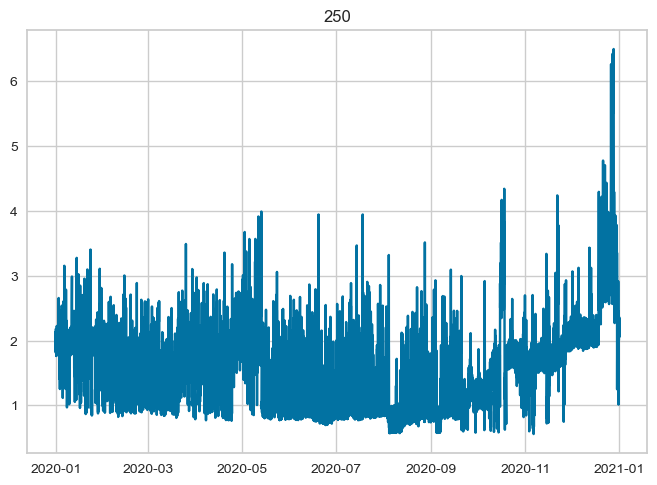

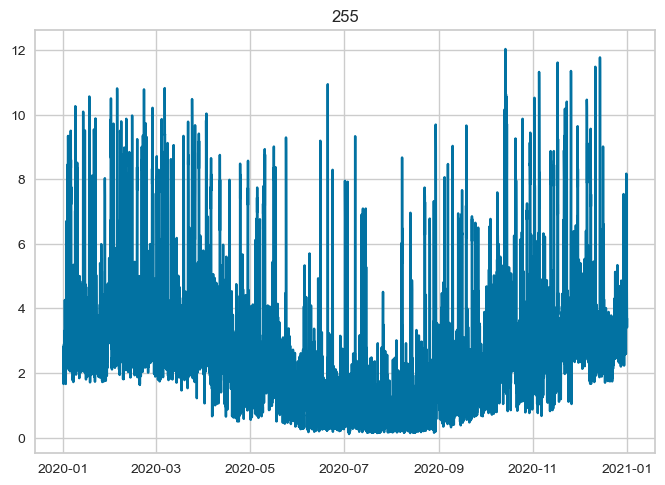

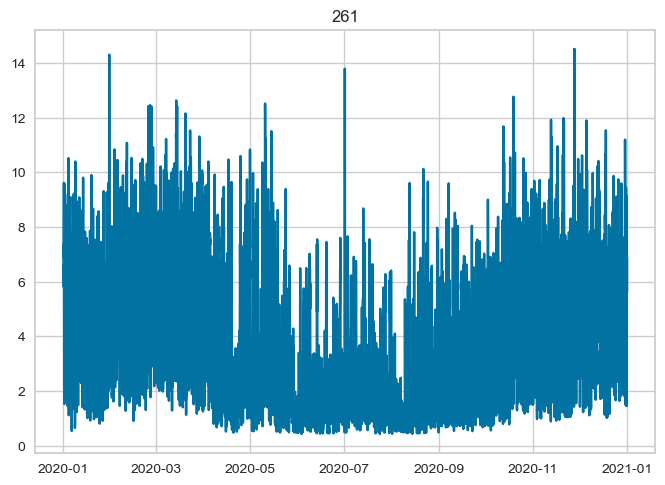

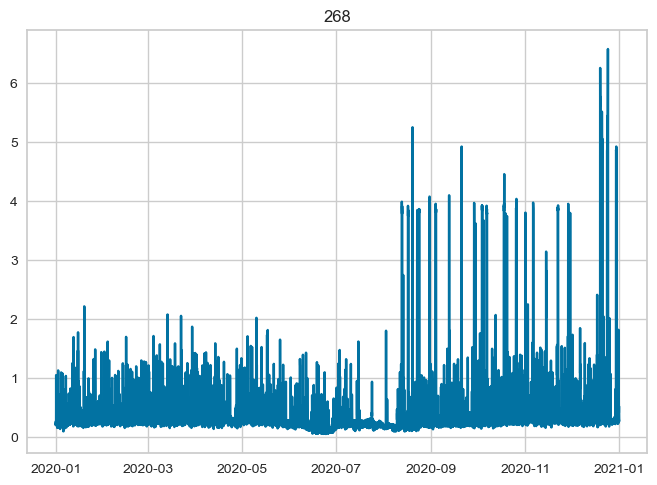

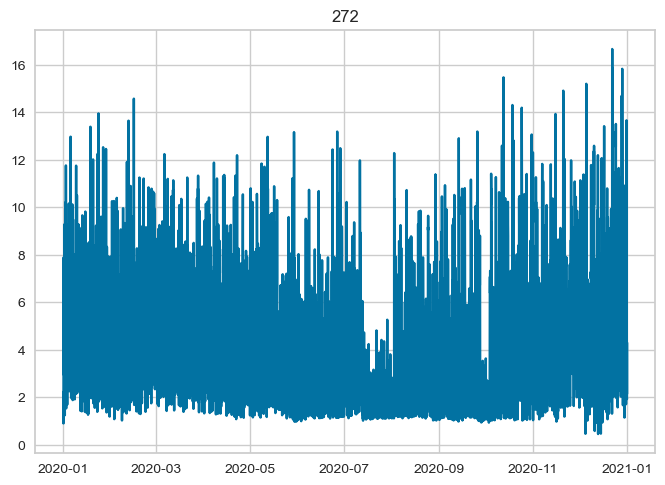

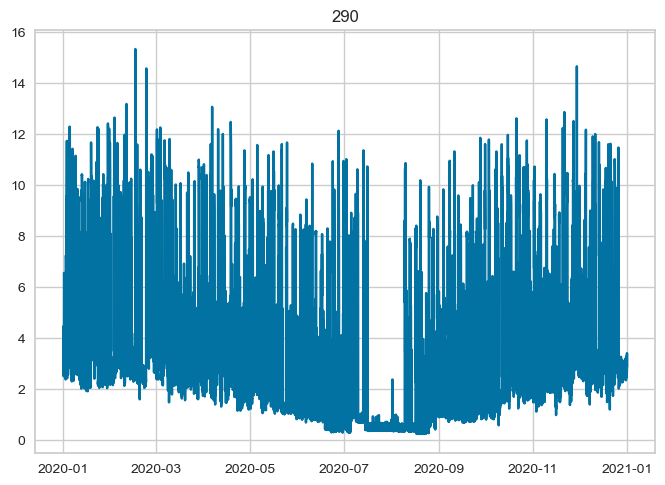

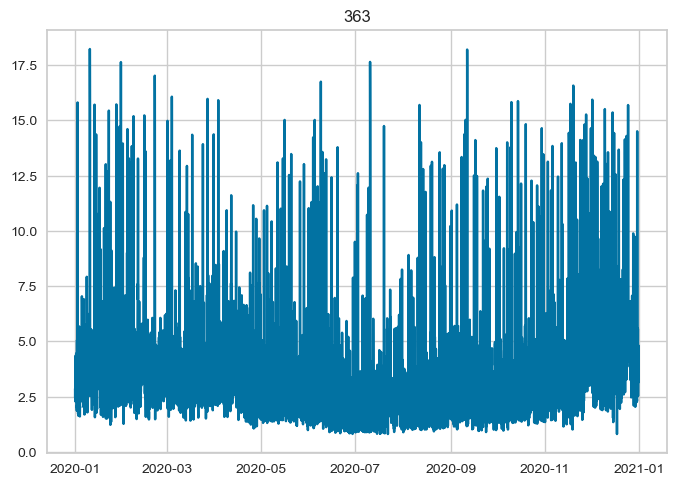

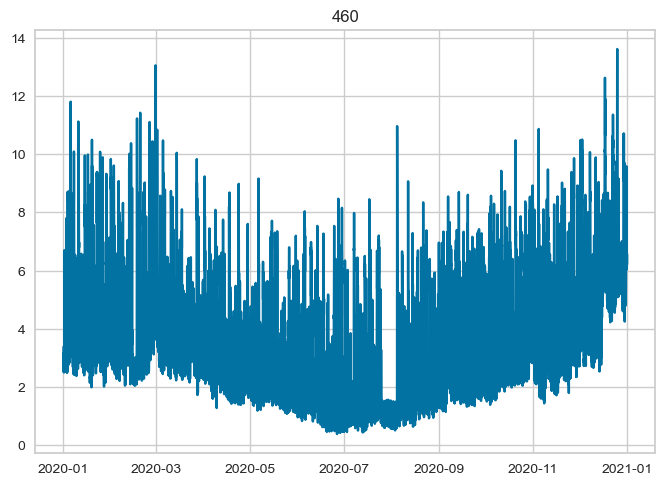

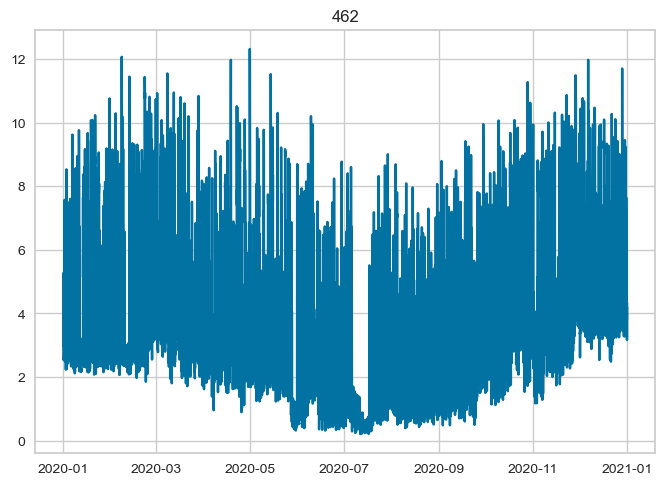

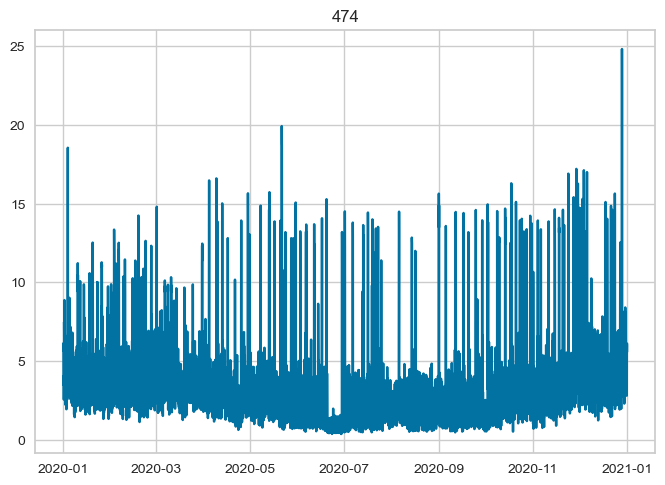

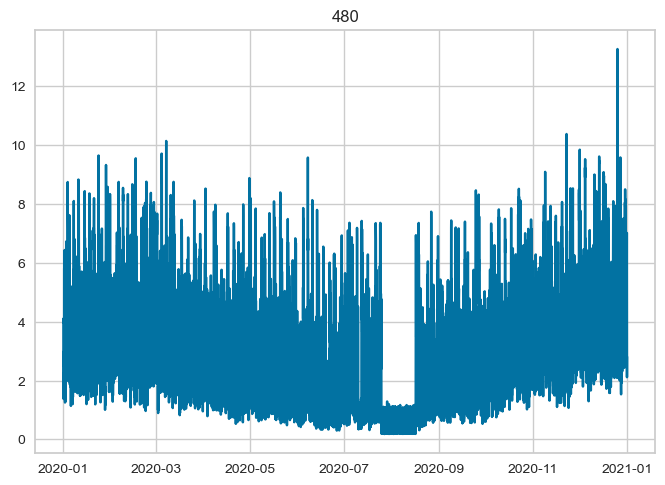

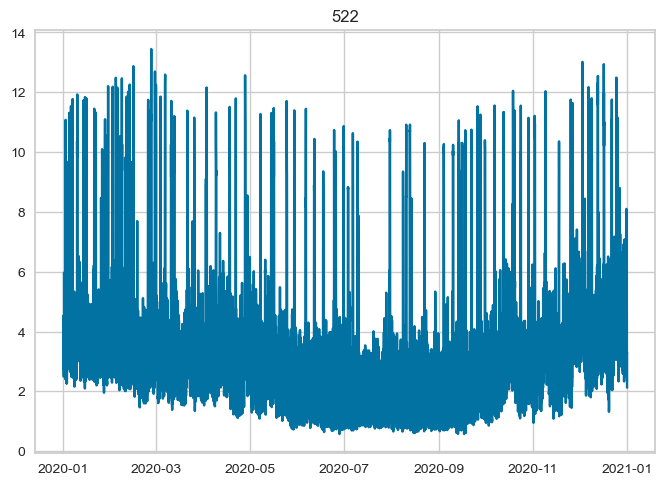

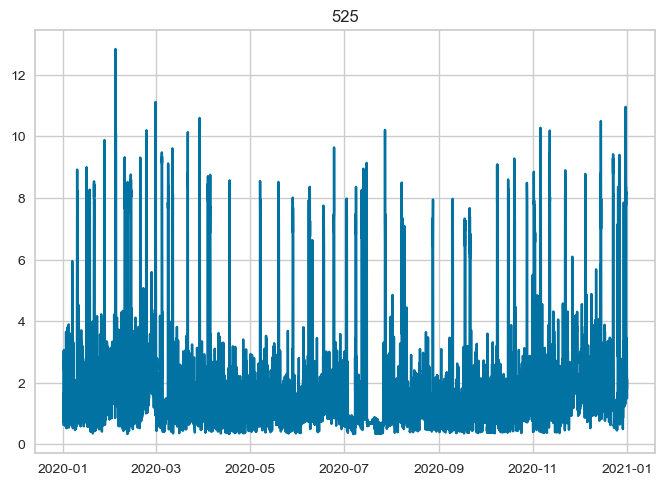

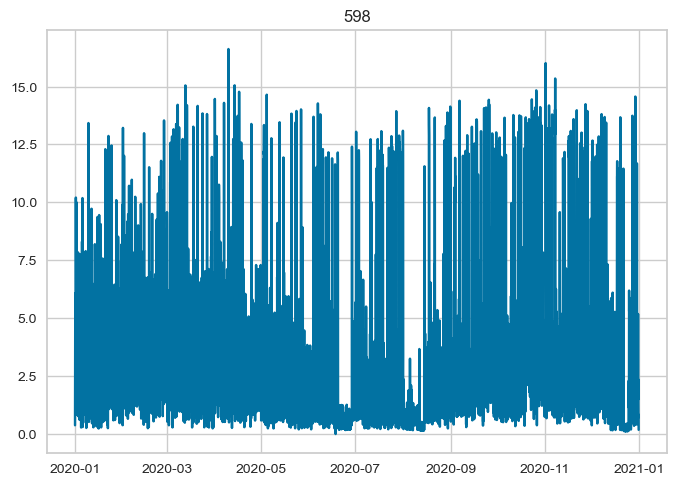

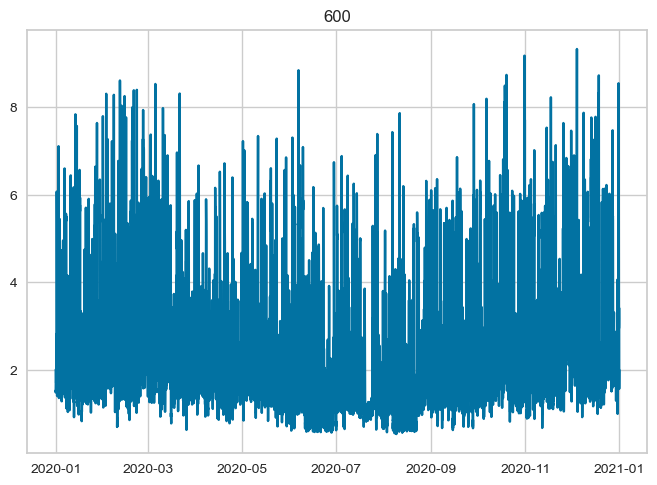

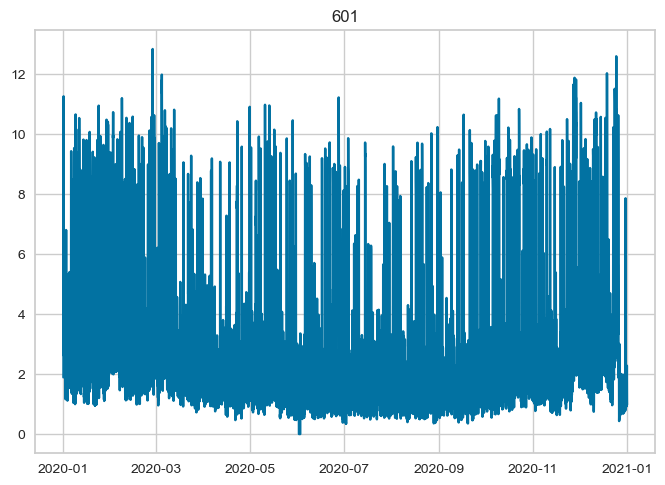

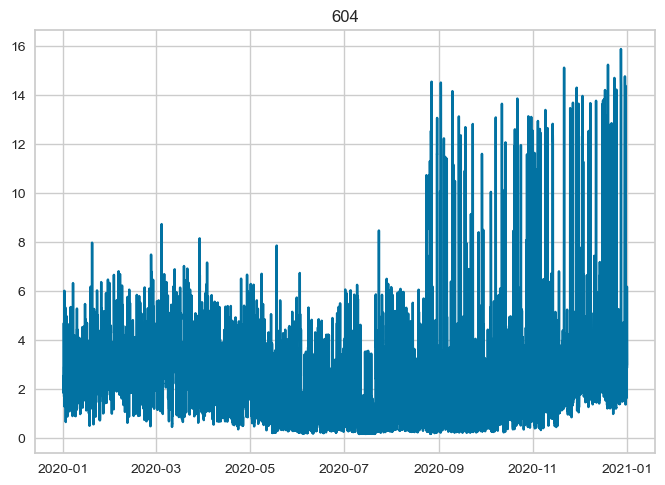

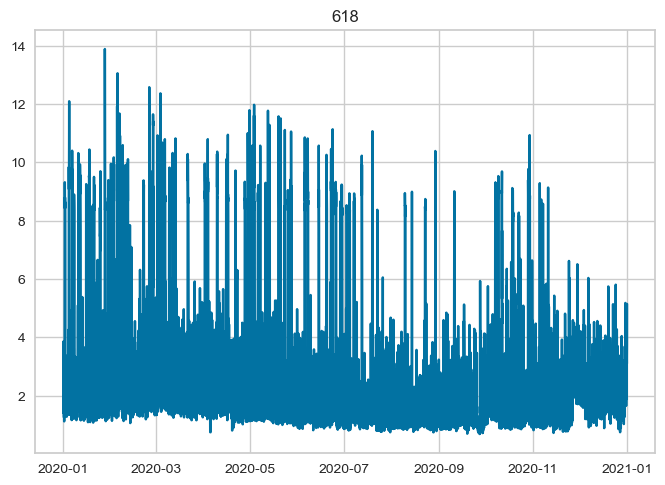

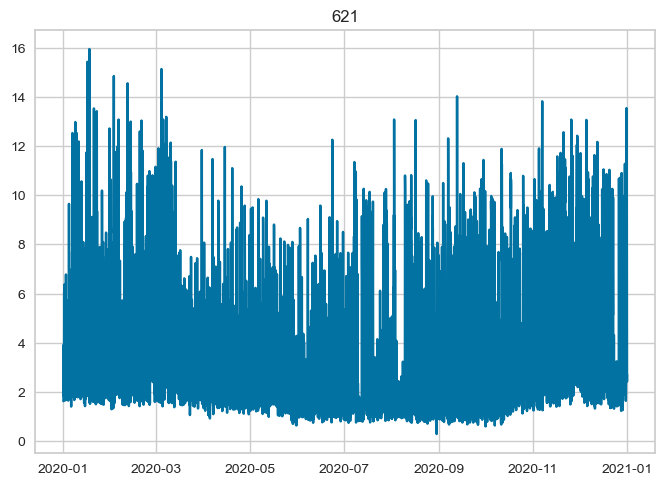

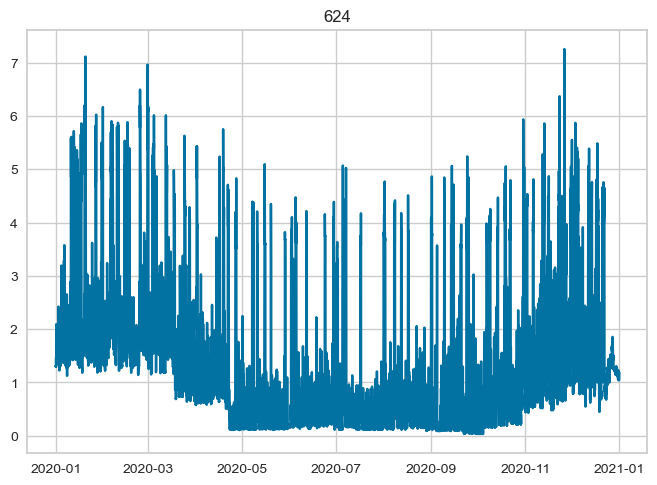

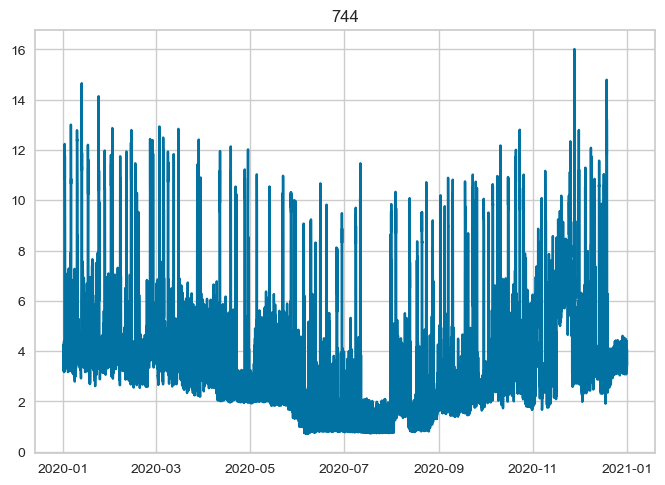

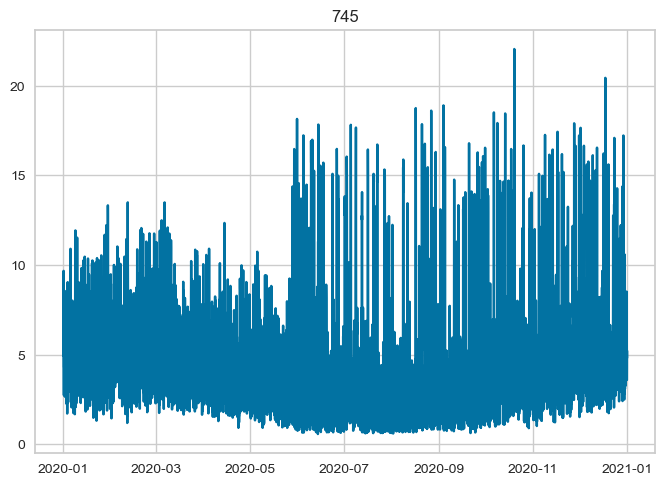

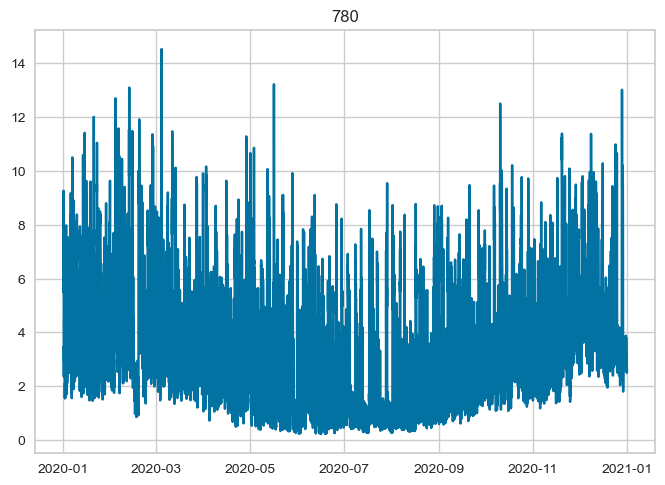

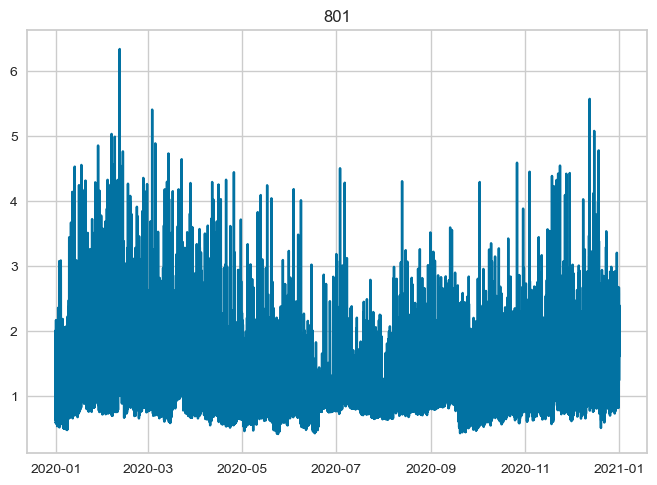

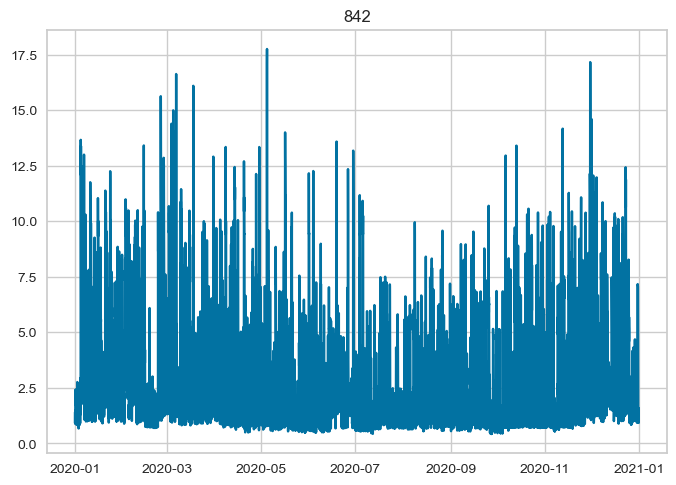

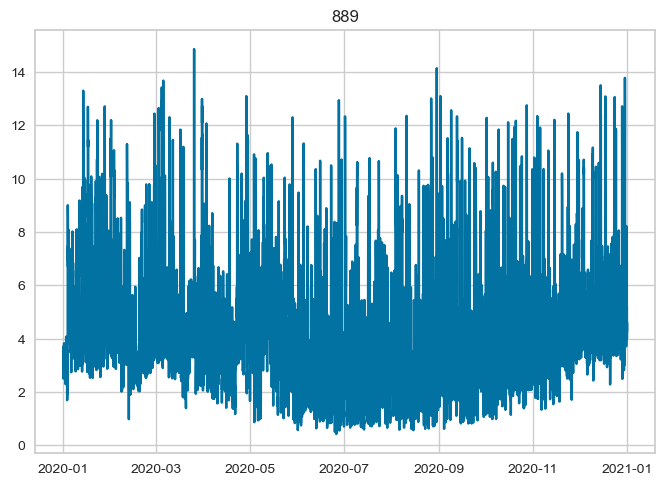

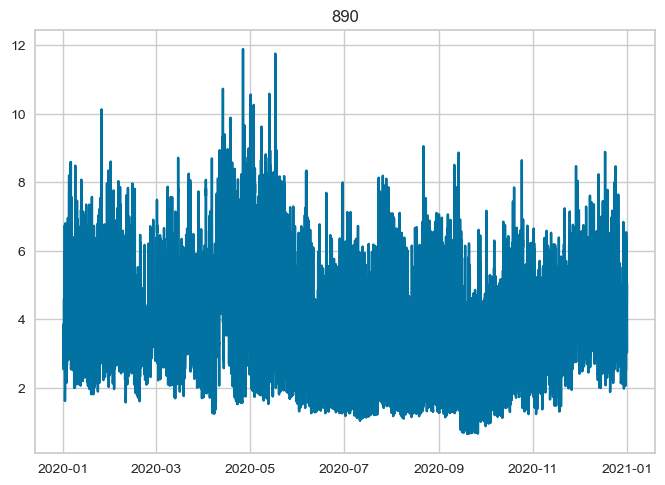

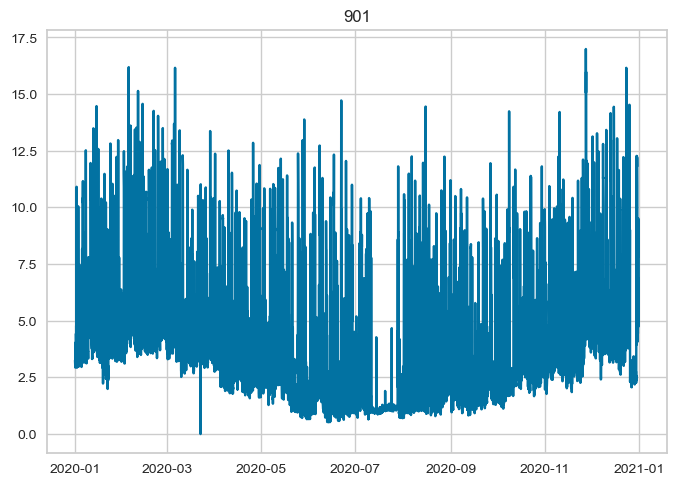

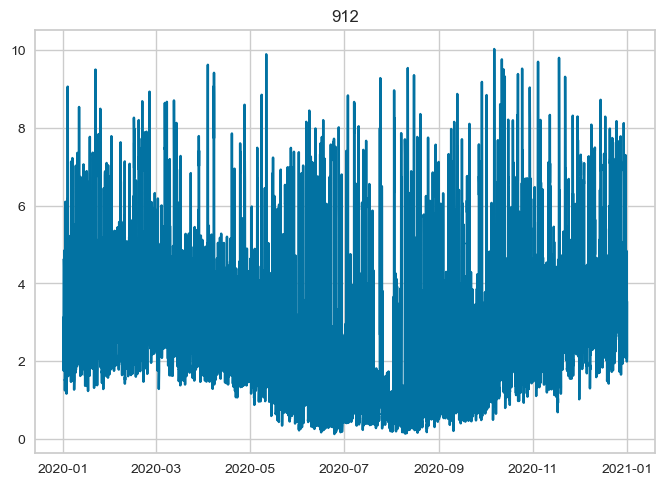

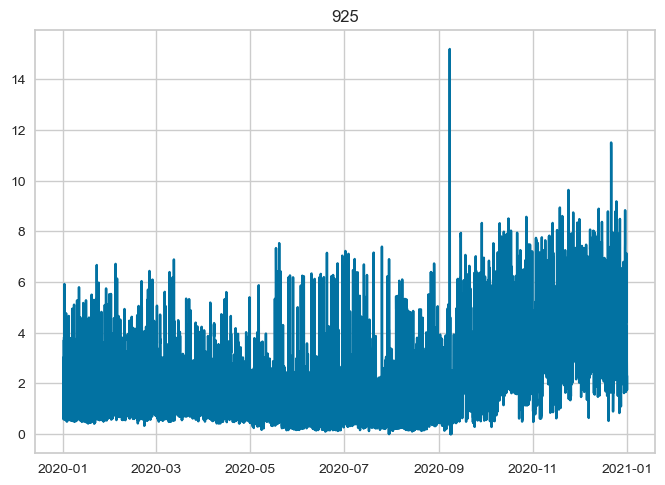

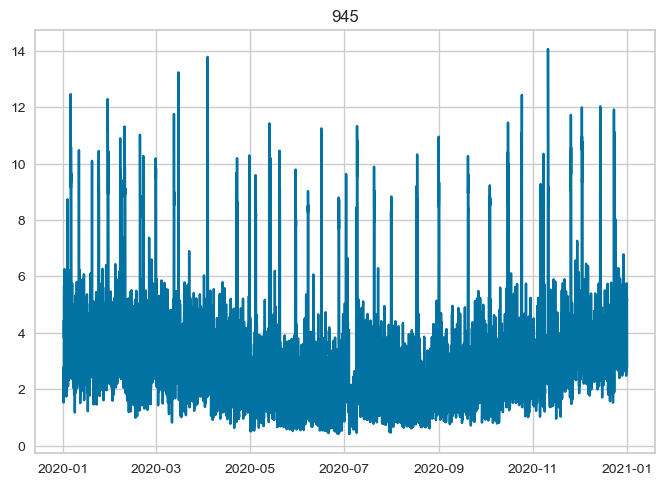

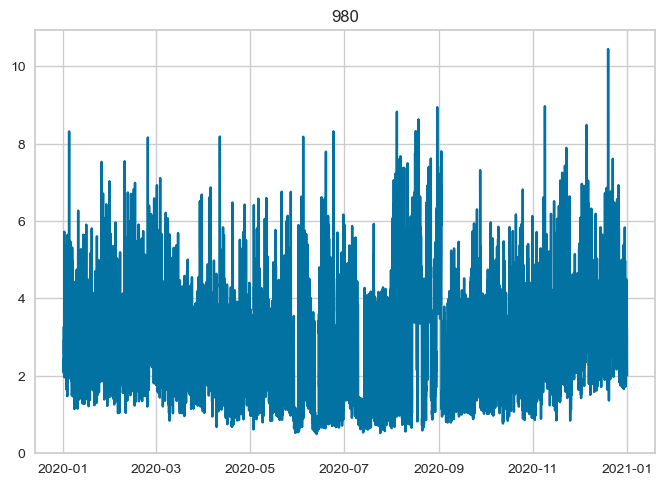

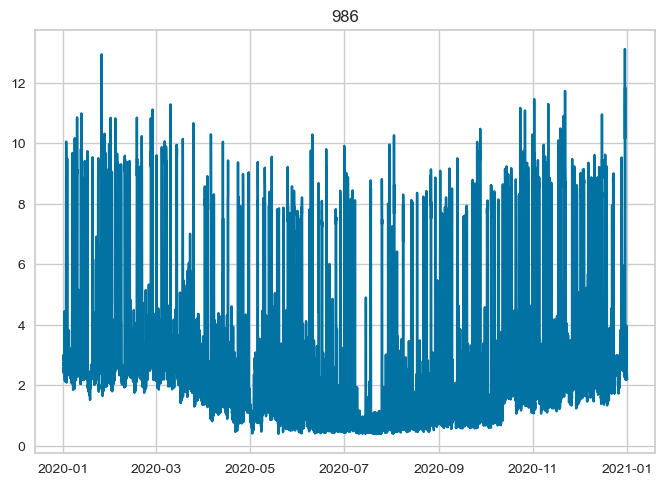

In [146]:
for h_i in df_clusters[df_clusters["clusters"] == 2].home_num:
    plt.plot(data[h_i]["consumption"])
    plt.title(h_i)
    plt.show()

In [157]:
df_clusters.to_csv("../../data/cluster_idx.csv", index=False)